In [6]:
import json

# Load the JSON
with open('/content/user-wallet-transactions.json', 'r') as f:
    raw_data = json.load(f)

print(f"Type of data: {type(raw_data)}")
print(f"Number of records: {len(raw_data)}")

# Print first transaction
print("\nSample record:")
print(json.dumps(raw_data[0], indent=2))


Type of data: <class 'list'>
Number of records: 100000

Sample record:
{
  "_id": {
    "$oid": "681d38fed63812d4655f571a"
  },
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "network": "polygon",
  "protocol": "aave_v2",
  "txHash": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190",
  "logId": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit",
  "timestamp": 1629178166,
  "blockNumber": 1629178166,
  "action": "deposit",
  "actionData": {
    "type": "Deposit",
    "amount": "2000000000",
    "assetSymbol": "USDC",
    "assetPriceUSD": "0.9938318274296357543568636362026045",
    "poolId": "0x2791bca1f2de4661ed88a30c99a7a9449aa84174",
    "userId": "0x00000000001accfa9cef68cf5371a23025b6d4b6"
  },
  "__v": 0,
  "createdAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  },
  "updatedAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  }
}


In [7]:
import json
import pandas as pd

# Load JSON file
with open('/content/user-wallet-transactions.json', 'r') as f:
    raw_data = json.load(f)

print(f"Total transactions: {len(raw_data)}")

# Extract useful fields into a flat table
records = []

for tx in raw_data:
    record = {
        'wallet': tx.get('userWallet'),
        'action': tx.get('action'),
        'timestamp': tx.get('timestamp'),
    }

    # Extract from nested actionData
    ad = tx.get('actionData', {})
    record['amount'] = pd.to_numeric(ad.get('amount', 0), errors='coerce')
    record['asset'] = ad.get('assetSymbol')
    record['price_usd'] = pd.to_numeric(ad.get('assetPriceUSD', 0), errors='coerce')

    records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

# Drop rows with missing wallet or amount
df = df.dropna(subset=['wallet', 'amount'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

df.head()


Total transactions: 100000


,wallet,action,timestamp,amount,asset,price_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,2000000000,USDC,0.993832
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,145000000000000000000.0,WMATIC,1.970307
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,1000000000000000,WMATIC,0.922377
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,4000000000000000,WMATIC,1.057483
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,501548,USDC,1.002130


In [4]:
df.columns
df.iloc[0]


,0
_id,{'$oid': '681d38fed63812d4655f571a'}
userWallet,0x00000000001accfa9cef68cf5371a23025b6d4b6
network,polygon
protocol,aave_v2
txHash,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...
logId,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...
timestamp,1629178166
blockNumber,1629178166
action,deposit
actionData,"{'type': 'Deposit', 'amount': '2000000000', 'a..."


In [8]:
def feature_engineering(df):
    grouped = df.groupby('wallet')

    feature_df = pd.DataFrame()
    feature_df['total_txns'] = grouped.size()
    feature_df['n_deposits'] = grouped.apply(lambda g: (g['action'] == 'deposit').sum())
    feature_df['n_borrows'] = grouped.apply(lambda g: (g['action'] == 'borrow').sum())
    feature_df['n_repays'] = grouped.apply(lambda g: (g['action'] == 'repay').sum())
    feature_df['n_redeems'] = grouped.apply(lambda g: (g['action'] == 'redeemUnderlying').sum())
    feature_df['n_liquidations'] = grouped.apply(lambda g: (g['action'] == 'liquidationCall').sum())

    feature_df['total_amount'] = grouped['amount'].sum()
    feature_df['avg_amount'] = grouped['amount'].mean()
    feature_df['std_amount'] = grouped['amount'].std()

    feature_df['avg_price_usd'] = grouped['price_usd'].mean()
    feature_df['unique_assets'] = grouped['asset'].nunique()

    feature_df = feature_df.fillna(0)
    return feature_df.reset_index()


In [9]:
# Apply feature extraction
features = feature_engineering(df)
features.head()


/tmp/ipython-input-8-199821670.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df['n_deposits'] = grouped.apply(lambda g: (g['action'] == 'deposit').sum())
/tmp/ipython-input-8-199821670.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df['n_borrows'] = grouped.apply(lambda g: (g['action'] == 'borrow').sum())
/tmp/ipython-input-8-199821670.py:8: DeprecationWarning: DataFrameGroupBy.ap

,wallet,total_txns,n_deposits,n_borrows,n_repays,n_redeems,n_liquidations,total_amount,avg_amount,std_amount,avg_price_usd,unique_assets
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0,2000000000,2.000000e+09,0.000000e+00,0.993832,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0,145000000000000000000.0,1.450000e+20,0.000000e+00,1.970307,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0,5000000000000000,2.500000e+15,2.121320e+15,0.989930,1
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0,4835297129866918825,2.844292e+17,1.084901e+18,13641.037951,4
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,0,173500770199755934400512.0,4.348390e+20,1.684377e+21,142.224827,6


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Prepare feature matrix
X = features.drop('wallet', axis=1)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Map clusters to credit scores
cluster_score_map = {
    0: 900,
    1: 700,
    2: 500,
    3: 300,
    4: 100
}

features['cluster'] = clusters
features['credit_score'] = features['cluster'].map(cluster_score_map)

# Final result
score_df = features[['wallet', 'credit_score']]
score_df.head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,900
1,0x000000000051d07a4fb3bd10121a343d85818da6,900
2,0x000000000096026fb41fc39f9875d164bd82e2dc,900
3,0x0000000000e189dd664b9ab08a33c4839953852c,300
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,100


In [11]:
score_df.to_csv("/content/wallet_scores.csv", index=False)
print("✅ Scores saved to: wallet_scores.csv")


✅ Scores saved to: wallet_scores.csv


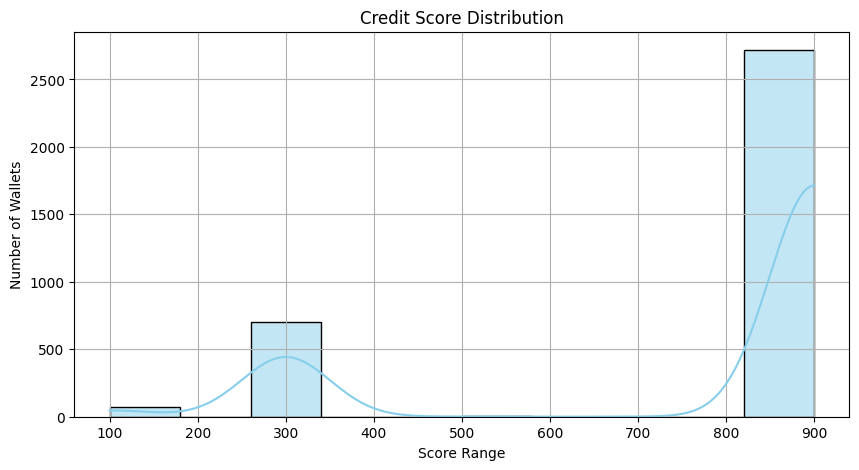

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(score_df['credit_score'], bins=10, kde=True, color='skyblue')
plt.title("Credit Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


In [13]:
top_wallets = score_df.sort_values(by='credit_score', ascending=False).head(10)
bottom_wallets = score_df.sort_values(by='credit_score').head(10)

top_wallets.to_csv("/content/top_wallets.csv", index=False)
bottom_wallets.to_csv("/content/bottom_wallets.csv", index=False)
